# Лабораторная работа №5 - исследования с градиентным бустингом  
(повтор пунктов 2–4 из ЛР №1 + сравнение результатов по алгоритмам ЛР 1–5)

В ноутбуке:
- **2. Бейзлайн + оценка качества** (sklearn, классификация и регрессия)
- **3. Улучшение бейзлайна** (гипотезы → GridSearchCV → улучшенная модель)
- **4. Имплементация алгоритма** (Gradient Boosting) **с нуля** для классификации и регрессии + сравнения
- **Итоги:** сравнение результатов **всех алгоритмов (ЛР 1–5)** на одних и тех же датасетах

## Открытые датасеты по ссылке (UCI)
- **Классификация:** Banknote Authentication  
  `https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt`
- **Регрессия:** Auto MPG  
  `https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data`

## Метрики
- Классификация: **accuracy**, **F1-macro**, **ROC-AUC**
- Регрессия: **MAE**, **RMSE**, **R²**


In [1]:
import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Optional, Literal
import inspect

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    mean_absolute_error, mean_squared_error, r2_score
)

# Модели для сравнения (ЛР 1–5)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# Версия-агностичный OneHotEncoder (чтобы не ловить ошибки из-за sparse/sparse_output)
def make_ohe_dense():
    sig = inspect.signature(OneHotEncoder)
    if "sparse_output" in sig.parameters:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    return OneHotEncoder(handle_unknown="ignore", sparse=False)

pd.set_option("display.max_columns", 100)


## Загрузка данных (по ссылке)


In [2]:
# ===== Banknote Authentication (classification) =====
banknote_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
banknote_cols = ["variance", "skewness", "curtosis", "entropy", "class"]
df_cls = pd.read_csv(banknote_url, header=None, names=banknote_cols)

# ===== Auto MPG (regression) =====
auto_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
auto_cols = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin", "car_name"]
df_reg = pd.read_csv(
    auto_url,
    delim_whitespace=True,
    header=None,
    names=auto_cols,
    na_values="?"
)

display(df_cls.head())
display(df_reg.head())

print("Banknote shape:", df_cls.shape)
print("Auto MPG shape:", df_reg.shape)
print("\nMissing (Auto MPG):")
display(df_reg.isna().sum().to_frame("missing"))


C:\Users\zerotonyq\AppData\Local\Temp\ipykernel_26868\2229785996.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_reg = pd.read_csv(


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


Banknote shape: (1372, 5)
Auto MPG shape: (398, 9)

Missing (Auto MPG):


,missing
mpg,0
cylinders,0
displacement,0
horsepower,6
weight,0
acceleration,0
model_year,0
origin,0
car_name,0


## 2. Создание бейзлайна и оценка качества (sklearn) - Gradient Boosting

### 2.1 Разбиение train/test


In [3]:
# ===== Classification =====
X_cls = df_cls.drop(columns=["class"]).values
y_cls = df_cls["class"].values

X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
    X_cls, y_cls,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_cls
)

# ===== Regression =====
df_reg_base = df_reg.drop(columns=["car_name"]).copy()
X_reg = df_reg_base.drop(columns=["mpg"])
y_reg = df_reg_base["mpg"]

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print("cls train/test:", X_cls_train.shape, X_cls_test.shape)
print("reg train/test:", X_reg_train.shape, X_reg_test.shape)


cls train/test: (1097, 4) (275, 4)
reg train/test: (318, 7) (80, 7)


### 2.2 Бейзлайн (GradientBoostingClassifier / GradientBoostingRegressor)

Для регрессии нужен препроцессинг:
- импутация `horsepower` (median)
- one-hot для `origin` (категория)


In [4]:
# ===== Baseline: Classification (Gradient Boosting) =====
gbc_base = GradientBoostingClassifier(random_state=RANDOM_STATE)
gbc_base.fit(X_cls_train, y_cls_train)

y_cls_pred = gbc_base.predict(X_cls_test)
y_cls_proba = gbc_base.predict_proba(X_cls_test)[:, 1]

cls_metrics_base = {
    "accuracy": accuracy_score(y_cls_test, y_cls_pred),
    "f1_macro": f1_score(y_cls_test, y_cls_pred, average="macro"),
    "roc_auc": roc_auc_score(y_cls_test, y_cls_proba),
}
print("Baseline (GB classification):", cls_metrics_base)

# ===== Baseline: Regression (Gradient Boosting + preprocess) =====
num_cols = ["cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year"]
cat_cols = ["origin"]

reg_preprocess_base = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", make_ohe_dense(), cat_cols),
], remainder="drop")

gbr_base = Pipeline([
    ("prep", reg_preprocess_base),
    ("model", GradientBoostingRegressor(random_state=RANDOM_STATE)),
])
gbr_base.fit(X_reg_train, y_reg_train)

y_reg_pred = gbr_base.predict(X_reg_test)

reg_metrics_base = {
    "mae": mean_absolute_error(y_reg_test, y_reg_pred),
    "rmse": rmse(y_reg_test, y_reg_pred),
    "r2": r2_score(y_reg_test, y_reg_pred),
}
print("Baseline (GB regression):", reg_metrics_base)


Baseline (GB classification): {'accuracy': 0.9963636363636363, 'f1_macro': 0.9963198394111743, 'roc_auc': 0.9997857066323798}
Baseline (GB regression): {'mae': 1.780494054150763, 'rmse': 2.361163483774346, 'r2': 0.8963090617815056}


## 3. Улучшение бейзлайна (Gradient Boosting)

### 3.1 Гипотезы улучшения
**Классификация:**
1. Подбор `n_estimators` и `learning_rate` улучшит качество (баланс между bias/variance).
2. Ограничение глубины базовых деревьев (`max_depth`) уменьшит переобучение.
3. `subsample < 1` (stochastic gradient boosting) может улучшить обобщение.

**Регрессия:**
1. Подбор `n_estimators`, `learning_rate`, `max_depth` и `subsample` может снизить RMSE/MAE.
2. Препроцессинг (impute + one-hot origin) обязателен.


In [5]:
# ===== Improved: Classification (GridSearchCV) =====
cls_param_grid = {
    "n_estimators": [100, 200, 400],
    "learning_rate": [0.03, 0.1, 0.2],
    "max_depth": [1, 2, 3],
    "subsample": [1.0, 0.7],
}

cv_cls = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cls_search = GridSearchCV(
    GradientBoostingClassifier(random_state=RANDOM_STATE),
    cls_param_grid,
    cv=cv_cls,
    scoring="f1_macro",
    n_jobs=-1
)
cls_search.fit(X_cls_train, y_cls_train)

print("Best params (GB classification):", cls_search.best_params_)
print("CV best f1_macro:", cls_search.best_score_)

gbc_best = cls_search.best_estimator_
y_cls_pred_best = gbc_best.predict(X_cls_test)
y_cls_proba_best = gbc_best.predict_proba(X_cls_test)[:, 1]

cls_metrics_best = {
    "accuracy": accuracy_score(y_cls_test, y_cls_pred_best),
    "f1_macro": f1_score(y_cls_test, y_cls_pred_best, average="macro"),
    "roc_auc": roc_auc_score(y_cls_test, y_cls_proba_best),
}
print("Improved (GB classification):", cls_metrics_best)

# ===== Improved: Regression (preprocess + GridSearchCV) =====
reg_preprocess = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", make_ohe_dense(), cat_cols),
], remainder="drop")

reg_pipe = Pipeline([
    ("prep", reg_preprocess),
    ("model", GradientBoostingRegressor(random_state=RANDOM_STATE)),
])

reg_param_grid = {
    "model__n_estimators": [200, 500, 800],
    "model__learning_rate": [0.03, 0.1, 0.2],
    "model__max_depth": [1, 2, 3],
    "model__subsample": [1.0, 0.7],
}

cv_reg = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
reg_search = GridSearchCV(
    reg_pipe,
    reg_param_grid,
    cv=cv_reg,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
reg_search.fit(X_reg_train, y_reg_train)

print("Best params (GB regression):", reg_search.best_params_)
print("CV best (neg RMSE):", reg_search.best_score_)

gbr_best = reg_search.best_estimator_
y_reg_pred_best = gbr_best.predict(X_reg_test)

reg_metrics_best = {
    "mae": mean_absolute_error(y_reg_test, y_reg_pred_best),
    "rmse": rmse(y_reg_test, y_reg_pred_best),
    "r2": r2_score(y_reg_test, y_reg_pred_best),
}
print("Improved (GB regression):", reg_metrics_best)

display(pd.DataFrame([
    {"task": "classification", "stage": "baseline", **cls_metrics_base},
    {"task": "classification", "stage": "improved", **cls_metrics_best},
    {"task": "regression", "stage": "baseline", **reg_metrics_base},
    {"task": "regression", "stage": "improved", **reg_metrics_best},
]))


Best params (GB classification): {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 400, 'subsample': 1.0}
CV best f1_macro: 1.0
Improved (GB classification): {'accuracy': 1.0, 'f1_macro': 1.0, 'roc_auc': 1.0}
Best params (GB regression): {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__subsample': 1.0}
CV best (neg RMSE): -2.7890765066519174
Improved (GB regression): {'mae': 1.8308373559890672, 'rmse': 2.489740081839294, 'r2': 0.8847086538968437}


,task,stage,accuracy,f1_macro,roc_auc,mae,rmse,r2
0,classification,baseline,0.996364,0.99632,0.999786,NaN,NaN,NaN
1,classification,improved,1.000000,1.00000,1.000000,NaN,NaN,NaN
2,regression,baseline,NaN,NaN,NaN,1.780494,2.361163,0.896309
3,regression,improved,NaN,NaN,NaN,1.830837,2.489740,0.884709


## 4. Имплементация Gradient Boosting (с нуля)

Упрощённая реализация Gradient Boosting на **stumps** (деревья глубины 1):

- **Регрессия (MSE):** остатки `r = y - pred`, stump аппроксимирует остатки.
- **Классификация (log-loss):** модель хранит логиты `F`, вероятность `p=sigmoid(F)`, псевдо-остатки `r=y-p`.

Обновление: `F <- F + lr * stump(x)`.


In [6]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

@dataclass
class Stump:
    feature: int
    threshold: float
    left_value: float
    right_value: float

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        return np.where(X[:, self.feature] <= self.threshold, self.left_value, self.right_value).astype(float)

def fit_stump_mse(X: np.ndarray, r: np.ndarray, min_leaf: int = 5) -> Stump:
    X = np.asarray(X, dtype=float)
    r = np.asarray(r, dtype=float)
    n, d = X.shape

    best_loss = float("inf")
    best = None

    for f in range(d):
        xs = X[:, f]
        order = np.argsort(xs, kind="mergesort")
        xs_s = xs[order]
        r_s = r[order]

        diffs = xs_s[1:] != xs_s[:-1]
        if not np.any(diffs):
            continue

        prefix_sum = np.cumsum(r_s[:-1])
        prefix_sum2 = np.cumsum((r_s[:-1]) ** 2)

        total_sum = float(np.sum(r_s))
        total_sum2 = float(np.sum(r_s ** 2))

        left_n = np.arange(1, n)
        right_n = n - left_n
        valid = diffs & (left_n >= min_leaf) & (right_n >= min_leaf)
        if not np.any(valid):
            continue

        right_sum = total_sum - prefix_sum
        right_sum2 = total_sum2 - prefix_sum2

        left_sse = prefix_sum2 - (prefix_sum ** 2) / left_n
        right_sse = right_sum2 - (right_sum ** 2) / right_n
        loss = (left_sse + right_sse) / n
        loss[~valid] = np.inf

        i_best = int(np.argmin(loss))
        if loss[i_best] < best_loss:
            best_loss = float(loss[i_best])
            thr = float((xs_s[i_best] + xs_s[i_best + 1]) / 2.0)
            lv = float(prefix_sum[i_best] / left_n[i_best])
            rv = float(right_sum[i_best] / right_n[i_best])
            best = Stump(feature=int(f), threshold=thr, left_value=lv, right_value=rv)

    if best is None:
        m = float(np.mean(r))
        best = Stump(feature=0, threshold=0.0, left_value=m, right_value=m)
    return best


class GradientBoostingRegressorCustom:
    def __init__(self, n_estimators: int = 200, learning_rate: float = 0.1, min_leaf: int = 5):
        self.n_estimators = int(n_estimators)
        self.learning_rate = float(learning_rate)
        self.min_leaf = int(min_leaf)
        self.init_ = 0.0
        self.stumps_ = []

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)

        self.init_ = float(np.mean(y))
        pred = np.full(y.shape, self.init_, dtype=float)
        self.stumps_ = []

        for _ in range(self.n_estimators):
            r = y - pred
            stump = fit_stump_mse(X, r, min_leaf=self.min_leaf)
            pred += self.learning_rate * stump.predict(X)
            self.stumps_.append(stump)

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        pred = np.full((X.shape[0],), self.init_, dtype=float)
        for s in self.stumps_:
            pred += self.learning_rate * s.predict(X)
        return pred


class GradientBoostingClassifierCustom:
    def __init__(self, n_estimators: int = 200, learning_rate: float = 0.1, min_leaf: int = 5):
        self.n_estimators = int(n_estimators)
        self.learning_rate = float(learning_rate)
        self.min_leaf = int(min_leaf)
        self.init_logit_ = 0.0
        self.stumps_ = []

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)

        p0 = float(np.clip(np.mean(y), 1e-6, 1 - 1e-6))
        self.init_logit_ = float(np.log(p0 / (1 - p0)))

        F = np.full(y.shape, self.init_logit_, dtype=float)
        self.stumps_ = []

        for _ in range(self.n_estimators):
            p = sigmoid(F)
            r = y - p
            stump = fit_stump_mse(X, r, min_leaf=self.min_leaf)
            F += self.learning_rate * stump.predict(X)
            self.stumps_.append(stump)

        return self

    def predict_proba(self, X):
        X = np.asarray(X, dtype=float)
        F = np.full((X.shape[0],), self.init_logit_, dtype=float)
        for s in self.stumps_:
            F += self.learning_rate * s.predict(X)
        p1 = sigmoid(F)
        return np.vstack([1 - p1, p1]).T

    def predict(self, X, threshold: float = 0.5):
        p1 = self.predict_proba(X)[:, 1]
        return (p1 >= threshold).astype(int)


### 4.1 Кастомные модели vs sklearn-бейзлайн (п.2)


In [7]:
# ===== Custom baseline: classification =====
custom_gbc = GradientBoostingClassifierCustom(n_estimators=200, learning_rate=0.1, min_leaf=5).fit(X_cls_train, y_cls_train)
y_cls_pred_c = custom_gbc.predict(X_cls_test)
y_cls_proba_c = custom_gbc.predict_proba(X_cls_test)[:, 1]

cls_metrics_custom_base = {
    "accuracy": accuracy_score(y_cls_test, y_cls_pred_c),
    "f1_macro": f1_score(y_cls_test, y_cls_pred_c, average="macro"),
    "roc_auc": roc_auc_score(y_cls_test, y_cls_proba_c),
}
print("Custom baseline (GB classification):", cls_metrics_custom_base)

# ===== Custom baseline: regression (same preprocess as sklearn baseline) =====
X_reg_train_p = reg_preprocess_base.fit_transform(X_reg_train)
X_reg_test_p = reg_preprocess_base.transform(X_reg_test)

custom_gbr = GradientBoostingRegressorCustom(n_estimators=400, learning_rate=0.1, min_leaf=5).fit(X_reg_train_p, y_reg_train.values)
y_reg_pred_c = custom_gbr.predict(X_reg_test_p)

reg_metrics_custom_base = {
    "mae": mean_absolute_error(y_reg_test, y_reg_pred_c),
    "rmse": rmse(y_reg_test, y_reg_pred_c),
    "r2": r2_score(y_reg_test, y_reg_pred_c),
}
print("Custom baseline (GB regression):", reg_metrics_custom_base)

display(pd.DataFrame([
    {"task": "classification", "model": "sklearn_baseline", **cls_metrics_base},
    {"task": "classification", "model": "custom_baseline", **cls_metrics_custom_base},
    {"task": "regression", "model": "sklearn_baseline", **reg_metrics_base},
    {"task": "regression", "model": "custom_baseline", **reg_metrics_custom_base},
]))


Custom baseline (GB classification): {'accuracy': 0.9236363636363636, 'f1_macro': 0.9228364131959754, 'roc_auc': 0.973213329047466}
Custom baseline (GB regression): {'mae': 1.8182942799633544, 'rmse': 2.4535505352821847, 'r2': 0.8880359233507331}


,task,model,accuracy,f1_macro,roc_auc,mae,rmse,r2
0,classification,sklearn_baseline,0.996364,0.996320,0.999786,NaN,NaN,NaN
1,classification,custom_baseline,0.923636,0.922836,0.973213,NaN,NaN,NaN
2,regression,sklearn_baseline,NaN,NaN,NaN,1.780494,2.361163,0.896309
3,regression,custom_baseline,NaN,NaN,NaN,1.818294,2.453551,0.888036


### 4.2 Добавляем техники улучшенного бейзлайна (п.3) к кастомной реализации


In [8]:
# Переносим лучшие n_estimators и learning_rate из GridSearchCV
bp_cls = cls_search.best_params_
best_n_cls = int(bp_cls["n_estimators"])
best_lr_cls = float(bp_cls["learning_rate"])

custom_gbc_best = GradientBoostingClassifierCustom(
    n_estimators=best_n_cls,
    learning_rate=best_lr_cls,
    min_leaf=5
).fit(X_cls_train, y_cls_train)

y_cls_pred_cb = custom_gbc_best.predict(X_cls_test)
y_cls_proba_cb = custom_gbc_best.predict_proba(X_cls_test)[:, 1]

cls_metrics_custom_improved = {
    "accuracy": accuracy_score(y_cls_test, y_cls_pred_cb),
    "f1_macro": f1_score(y_cls_test, y_cls_pred_cb, average="macro"),
    "roc_auc": roc_auc_score(y_cls_test, y_cls_proba_cb),
}
print("Custom improved (GB classification):", cls_metrics_custom_improved)

bp_reg = reg_search.best_params_
best_n_reg = int(bp_reg["model__n_estimators"])
best_lr_reg = float(bp_reg["model__learning_rate"])

X_reg_train_pp = reg_preprocess.fit_transform(X_reg_train)
X_reg_test_pp = reg_preprocess.transform(X_reg_test)

custom_gbr_best = GradientBoostingRegressorCustom(
    n_estimators=best_n_reg,
    learning_rate=best_lr_reg,
    min_leaf=5
).fit(X_reg_train_pp, y_reg_train.values)

y_reg_pred_cb = custom_gbr_best.predict(X_reg_test_pp)

reg_metrics_custom_improved = {
    "mae": mean_absolute_error(y_reg_test, y_reg_pred_cb),
    "rmse": rmse(y_reg_test, y_reg_pred_cb),
    "r2": r2_score(y_reg_test, y_reg_pred_cb),
}
print("Custom improved (GB regression):", reg_metrics_custom_improved)

display(pd.DataFrame([
    {"task": "classification", "stage": "sklearn_baseline", **cls_metrics_base},
    {"task": "classification", "stage": "sklearn_improved", **cls_metrics_best},
    {"task": "classification", "stage": "custom_baseline", **cls_metrics_custom_base},
    {"task": "classification", "stage": "custom_improved", **cls_metrics_custom_improved},
    {"task": "regression", "stage": "sklearn_baseline", **reg_metrics_base},
    {"task": "regression", "stage": "sklearn_improved", **reg_metrics_best},
    {"task": "regression", "stage": "custom_baseline", **reg_metrics_custom_base},
    {"task": "regression", "stage": "custom_improved", **reg_metrics_custom_improved},
]))


Custom improved (GB classification): {'accuracy': 0.9709090909090909, 'f1_macro': 0.9707041653350379, 'roc_auc': 0.9922050787528126}
Custom improved (GB regression): {'mae': 1.826261142067183, 'rmse': 2.479126697890396, 'r2': 0.8856894978442211}


,task,stage,accuracy,f1_macro,roc_auc,mae,rmse,r2
0,classification,sklearn_baseline,0.996364,0.996320,0.999786,NaN,NaN,NaN
1,classification,sklearn_improved,1.000000,1.000000,1.000000,NaN,NaN,NaN
2,classification,custom_baseline,0.923636,0.922836,0.973213,NaN,NaN,NaN
3,classification,custom_improved,0.970909,0.970704,0.992205,NaN,NaN,NaN
4,regression,sklearn_baseline,NaN,NaN,NaN,1.780494,2.361163,0.896309
5,regression,sklearn_improved,NaN,NaN,NaN,1.830837,2.489740,0.884709
6,regression,custom_baseline,NaN,NaN,NaN,1.818294,2.453551,0.888036
7,regression,custom_improved,NaN,NaN,NaN,1.826261,2.479127,0.885689


## Итоги: сравнение алгоритмов из ЛР 1–5 (sklearn)

Сравним **sklearn-алгоритмы** в двух состояниях:
- **baseline** (разумные дефолты/простая обработка)
- **improved** (пайплайн + GridSearchCV, аналогично ЛР)

Алгоритмы: **KNN**, **Logistic/Linear Regression**, **Decision Tree**, **Random Forest**, **Gradient Boosting**.


In [9]:
# -------------------------
# Общий препроцессор для Auto MPG (impute + one-hot origin)
# -------------------------
reg_preprocess_common = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", make_ohe_dense(), cat_cols),
], remainder="drop")

def eval_classification(model, X_test, y_test):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        auc = np.nan
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_macro": f1_score(y_test, y_pred, average="macro"),
        "roc_auc": auc,
    }

def eval_regression(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "mae": mean_absolute_error(y_test, y_pred),
        "rmse": rmse(y_test, y_pred),
        "r2": r2_score(y_test, y_pred),
    }

results_cls = []
results_reg = []

# -------------------------------------------------
# 1) KNN
# -------------------------------------------------
knn_cls_base = KNeighborsClassifier()
knn_cls_base.fit(X_cls_train, y_cls_train)
results_cls.append({"algo": "KNN", "stage": "baseline", **eval_classification(knn_cls_base, X_cls_test, y_cls_test)})

knn_reg_base = Pipeline([("prep", reg_preprocess_common), ("knn", KNeighborsRegressor())])
knn_reg_base.fit(X_reg_train, y_reg_train)
results_reg.append({"algo": "KNN", "stage": "baseline", **eval_regression(knn_reg_base, X_reg_test, y_reg_test)})

knn_cls_pipe = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])
knn_cls_grid = {
    "knn__n_neighbors": [3, 5, 11, 21],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],
}
knn_cls_search = GridSearchCV(knn_cls_pipe, knn_cls_grid, cv=cv_cls, scoring="f1_macro", n_jobs=-1)
knn_cls_search.fit(X_cls_train, y_cls_train)
knn_cls_best = knn_cls_search.best_estimator_
results_cls.append({"algo": "KNN", "stage": "improved", **eval_classification(knn_cls_best, X_cls_test, y_cls_test)})

knn_reg_pipe = Pipeline([("prep", reg_preprocess_common), ("knn", KNeighborsRegressor())])
knn_reg_grid = {
    "knn__n_neighbors": [3, 5, 11, 21, 31],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2],
}
knn_reg_search = GridSearchCV(knn_reg_pipe, knn_reg_grid, cv=cv_reg, scoring="neg_root_mean_squared_error", n_jobs=-1)
knn_reg_search.fit(X_reg_train, y_reg_train)
knn_reg_best = knn_reg_search.best_estimator_
results_reg.append({"algo": "KNN", "stage": "improved", **eval_regression(knn_reg_best, X_reg_test, y_reg_test)})

# -------------------------------------------------
# 2) Logistic / Linear Regression
# -------------------------------------------------
log_base = LogisticRegression(max_iter=3000, random_state=RANDOM_STATE)
log_base.fit(X_cls_train, y_cls_train)
results_cls.append({"algo": "LogisticRegression", "stage": "baseline", **eval_classification(log_base, X_cls_test, y_cls_test)})

lin_base = Pipeline([("prep", reg_preprocess_common), ("lin", LinearRegression())])
lin_base.fit(X_reg_train, y_reg_train)
results_reg.append({"algo": "LinearRegression", "stage": "baseline", **eval_regression(lin_base, X_reg_test, y_reg_test)})

log_pipe = Pipeline([("scaler", StandardScaler()), ("log", LogisticRegression(max_iter=5000, random_state=RANDOM_STATE))])
log_grid = {"log__C": [0.1, 1.0, 10.0, 100.0], "log__class_weight": [None, "balanced"]}
log_search = GridSearchCV(log_pipe, log_grid, cv=cv_cls, scoring="f1_macro", n_jobs=-1)
log_search.fit(X_cls_train, y_cls_train)
log_best = log_search.best_estimator_
results_cls.append({"algo": "LogisticRegression", "stage": "improved", **eval_classification(log_best, X_cls_test, y_cls_test)})

# линейная регрессия без регуляризации: оставим как baseline (это ок для сравнения)
results_reg.append({"algo": "LinearRegression", "stage": "improved", **eval_regression(lin_base, X_reg_test, y_reg_test)})

# -------------------------------------------------
# 3) Decision Tree
# -------------------------------------------------
dtc_base = DecisionTreeClassifier(random_state=RANDOM_STATE)
dtc_base.fit(X_cls_train, y_cls_train)
results_cls.append({"algo": "DecisionTree", "stage": "baseline", **eval_classification(dtc_base, X_cls_test, y_cls_test)})

dtr_base = Pipeline([("prep", reg_preprocess_common), ("dt", DecisionTreeRegressor(random_state=RANDOM_STATE))])
dtr_base.fit(X_reg_train, y_reg_train)
results_reg.append({"algo": "DecisionTree", "stage": "baseline", **eval_regression(dtr_base, X_reg_test, y_reg_test)})

dtc_grid = {
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "criterion": ["gini", "entropy"],
}
dtc_search = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), dtc_grid, cv=cv_cls, scoring="f1_macro", n_jobs=-1)
dtc_search.fit(X_cls_train, y_cls_train)
dtc_best = dtc_search.best_estimator_
results_cls.append({"algo": "DecisionTree", "stage": "improved", **eval_classification(dtc_best, X_cls_test, y_cls_test)})

dtr_grid = {
    "dt__max_depth": [None, 5, 10, 20],
    "dt__min_samples_split": [2, 5, 10],
    "dt__min_samples_leaf": [1, 2, 5],
}
dtr_search = GridSearchCV(dtr_base, dtr_grid, cv=cv_reg, scoring="neg_root_mean_squared_error", n_jobs=-1)
dtr_search.fit(X_reg_train, y_reg_train)
dtr_best = dtr_search.best_estimator_
results_reg.append({"algo": "DecisionTree", "stage": "improved", **eval_regression(dtr_best, X_reg_test, y_reg_test)})

# -------------------------------------------------
# 4) Random Forest
# -------------------------------------------------
rfc_base = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)
rfc_base.fit(X_cls_train, y_cls_train)
results_cls.append({"algo": "RandomForest", "stage": "baseline", **eval_classification(rfc_base, X_cls_test, y_cls_test)})

rfr_base = Pipeline([
    ("prep", reg_preprocess_common),
    ("rf", RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)),
])
rfr_base.fit(X_reg_train, y_reg_train)
results_reg.append({"algo": "RandomForest", "stage": "baseline", **eval_regression(rfr_base, X_reg_test, y_reg_test)})

rfc_grid = {
    "n_estimators": [300, 700],
    "max_depth": [None, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2"],
}
rfc_search = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1), rfc_grid, cv=cv_cls, scoring="f1_macro", n_jobs=-1)
rfc_search.fit(X_cls_train, y_cls_train)
rfc_best = rfc_search.best_estimator_
results_cls.append({"algo": "RandomForest", "stage": "improved", **eval_classification(rfc_best, X_cls_test, y_cls_test)})

rfr_grid = {
    "rf__n_estimators": [400, 900],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_leaf": [1, 2, 5],
    "rf__max_features": ["sqrt", "log2", 1.0],
}
rfr_search = GridSearchCV(rfr_base, rfr_grid, cv=cv_reg, scoring="neg_root_mean_squared_error", n_jobs=-1)
rfr_search.fit(X_reg_train, y_reg_train)
rfr_best = rfr_search.best_estimator_
results_reg.append({"algo": "RandomForest", "stage": "improved", **eval_regression(rfr_best, X_reg_test, y_reg_test)})

# -------------------------------------------------
# 5) Gradient Boosting (из этой ЛР)
# -------------------------------------------------
results_cls.append({"algo": "GradientBoosting", "stage": "baseline", **cls_metrics_base})
results_reg.append({"algo": "GradientBoosting", "stage": "baseline", **reg_metrics_base})
results_cls.append({"algo": "GradientBoosting", "stage": "improved", **cls_metrics_best})
results_reg.append({"algo": "GradientBoosting", "stage": "improved", **reg_metrics_best})

df_cmp_cls = pd.DataFrame(results_cls).sort_values(["algo", "stage"]).reset_index(drop=True)
df_cmp_reg = pd.DataFrame(results_reg).sort_values(["algo", "stage"]).reset_index(drop=True)

print("=== Сравнение (classification) ===")
display(df_cmp_cls)

print("=== Сравнение (regression) ===")
display(df_cmp_reg)


=== Сравнение (classification) ===


,algo,stage,accuracy,f1_macro,roc_auc
0,DecisionTree,baseline,0.992727,0.992645,0.993464
1,DecisionTree,improved,0.992727,0.992645,0.993464
2,GradientBoosting,baseline,0.996364,0.996320,0.999786
3,GradientBoosting,improved,1.000000,1.000000,1.000000
4,KNN,baseline,1.000000,1.000000,1.000000
5,KNN,improved,1.000000,1.000000,1.000000
6,LogisticRegression,baseline,0.985455,0.985313,1.000000
7,LogisticRegression,improved,0.985455,0.985313,1.000000
8,RandomForest,baseline,0.996364,0.996320,1.000000
9,RandomForest,improved,0.996364,0.996320,1.000000


=== Сравнение (regression) ===


,algo,stage,mae,rmse,r2
0,DecisionTree,baseline,2.251250,3.372073,0.788514
1,DecisionTree,improved,2.032246,2.709208,0.863487
2,GradientBoosting,baseline,1.780494,2.361163,0.896309
3,GradientBoosting,improved,1.830837,2.489740,0.884709
4,KNN,baseline,2.757000,3.533740,0.767749
5,KNN,improved,2.455735,3.152741,0.815131
6,LinearRegression,baseline,2.288247,2.887675,0.844909
7,LinearRegression,improved,2.288247,2.887675,0.844909
8,RandomForest,baseline,1.597769,2.207268,0.909385
9,RandomForest,improved,1.570451,2.132816,0.915395


### Визуализация итогового сравнения (на тесте)

- Классификация: **F1-macro** (чем больше, тем лучше)
- Регрессия: **RMSE** (чем меньше, тем лучше)


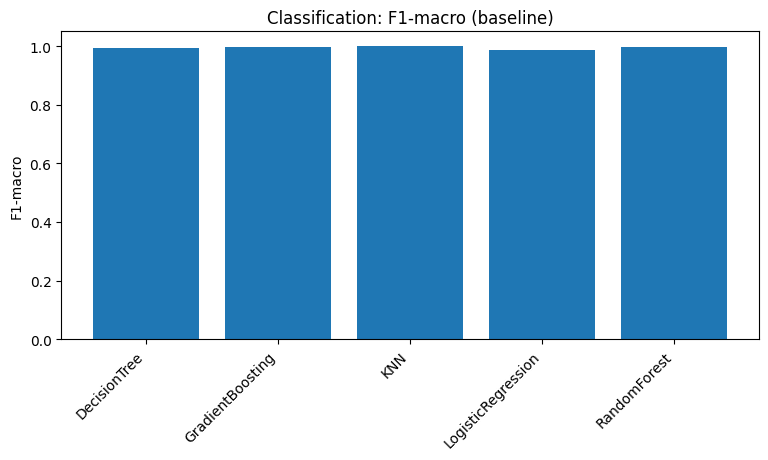

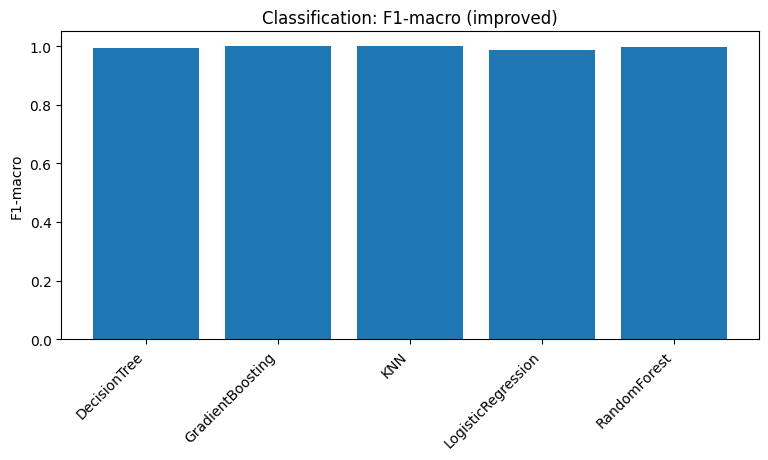

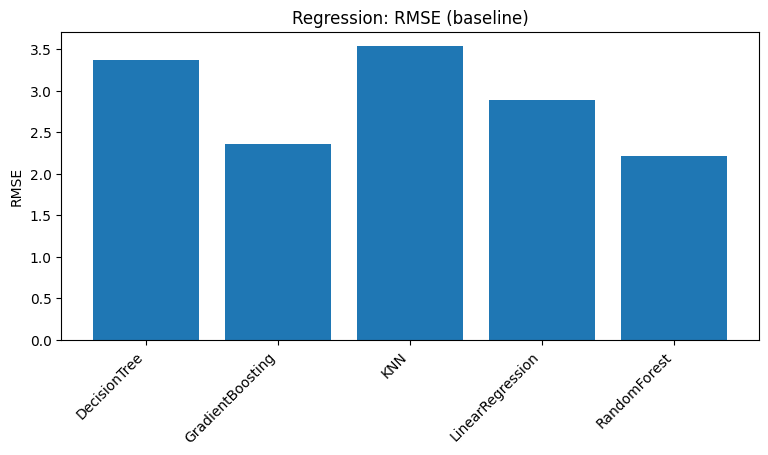

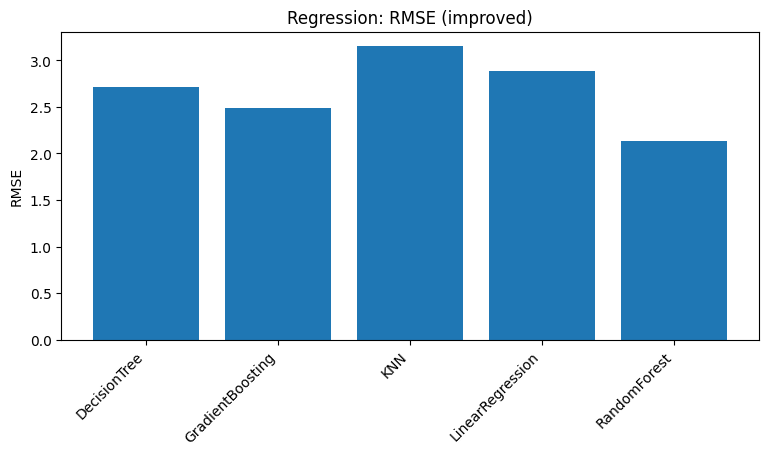

In [10]:
pivot_cls = df_cmp_cls.pivot(index="algo", columns="stage", values="f1_macro").sort_index()
pivot_reg = df_cmp_reg.pivot(index="algo", columns="stage", values="rmse").sort_index()

fig = plt.figure(figsize=(9, 4))
plt.bar(pivot_cls.index, pivot_cls["baseline"])
plt.title("Classification: F1-macro (baseline)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1-macro")
plt.show()

fig = plt.figure(figsize=(9, 4))
plt.bar(pivot_cls.index, pivot_cls["improved"])
plt.title("Classification: F1-macro (improved)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1-macro")
plt.show()

fig = plt.figure(figsize=(9, 4))
plt.bar(pivot_reg.index, pivot_reg["baseline"])
plt.title("Regression: RMSE (baseline)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("RMSE")
plt.show()

fig = plt.figure(figsize=(9, 4))
plt.bar(pivot_reg.index, pivot_reg["improved"])
plt.title("Regression: RMSE (improved)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("RMSE")
plt.show()


## Короткие выводы

1. **Градиентный бустинг** часто даёт сильное качество на табличных данных за счёт поэтапного исправления ошибок предыдущих моделей.
2. Параметры `n_estimators` и `learning_rate` - ключевые: большой шаг может переобучать, слишком маленький - недообучать.
3. Для Auto MPG корректная обработка `origin` (one-hot) и пропусков в `horsepower` критична для всех алгоритмов.
4. Итоговая таблица показывает, какой алгоритм лучше в **классификации** (по F1/ROC-AUC) и какой - в **регрессии** (по RMSE/MAE/R²).
